# ml lab8

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 0. download dataset

In [2]:
!./download_data.sh

data/sunspots does not exist, download:
  0%|                                               | 0.00/22.4k [00:00<?, ?B/s]
100%|███████████████████████████████████████| 22.4k/22.4k [00:00<00:00, 635kB/s]
Archive:  data/sunspots.zip
  inflating: data/sunspots/Sunspots.csv  


### 1. plot data & compute metrics

In [47]:
DATASET_DIR = './data/sunspots'

data = pd.read_csv(f'{DATASET_DIR}/Sunspots.csv', parse_dates=['Date'], index_col=['Date'])
data.rename(columns = {
    'Unnamed: 0': 'index',
    'Monthly Mean Total Sunspot Number': 'sunspots'
}, inplace = True)
data.head()

,index,sunspots
Date,,
1749-01-31,0,96.7
1749-02-28,1,104.3
1749-03-31,2,116.7
1749-04-30,3,92.8
1749-05-31,4,141.7


In [154]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3252 entries, 1749-01-31 to 2019-12-31
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     3252 non-null   int64  
 1   sunspots  3252 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 76.2 KB


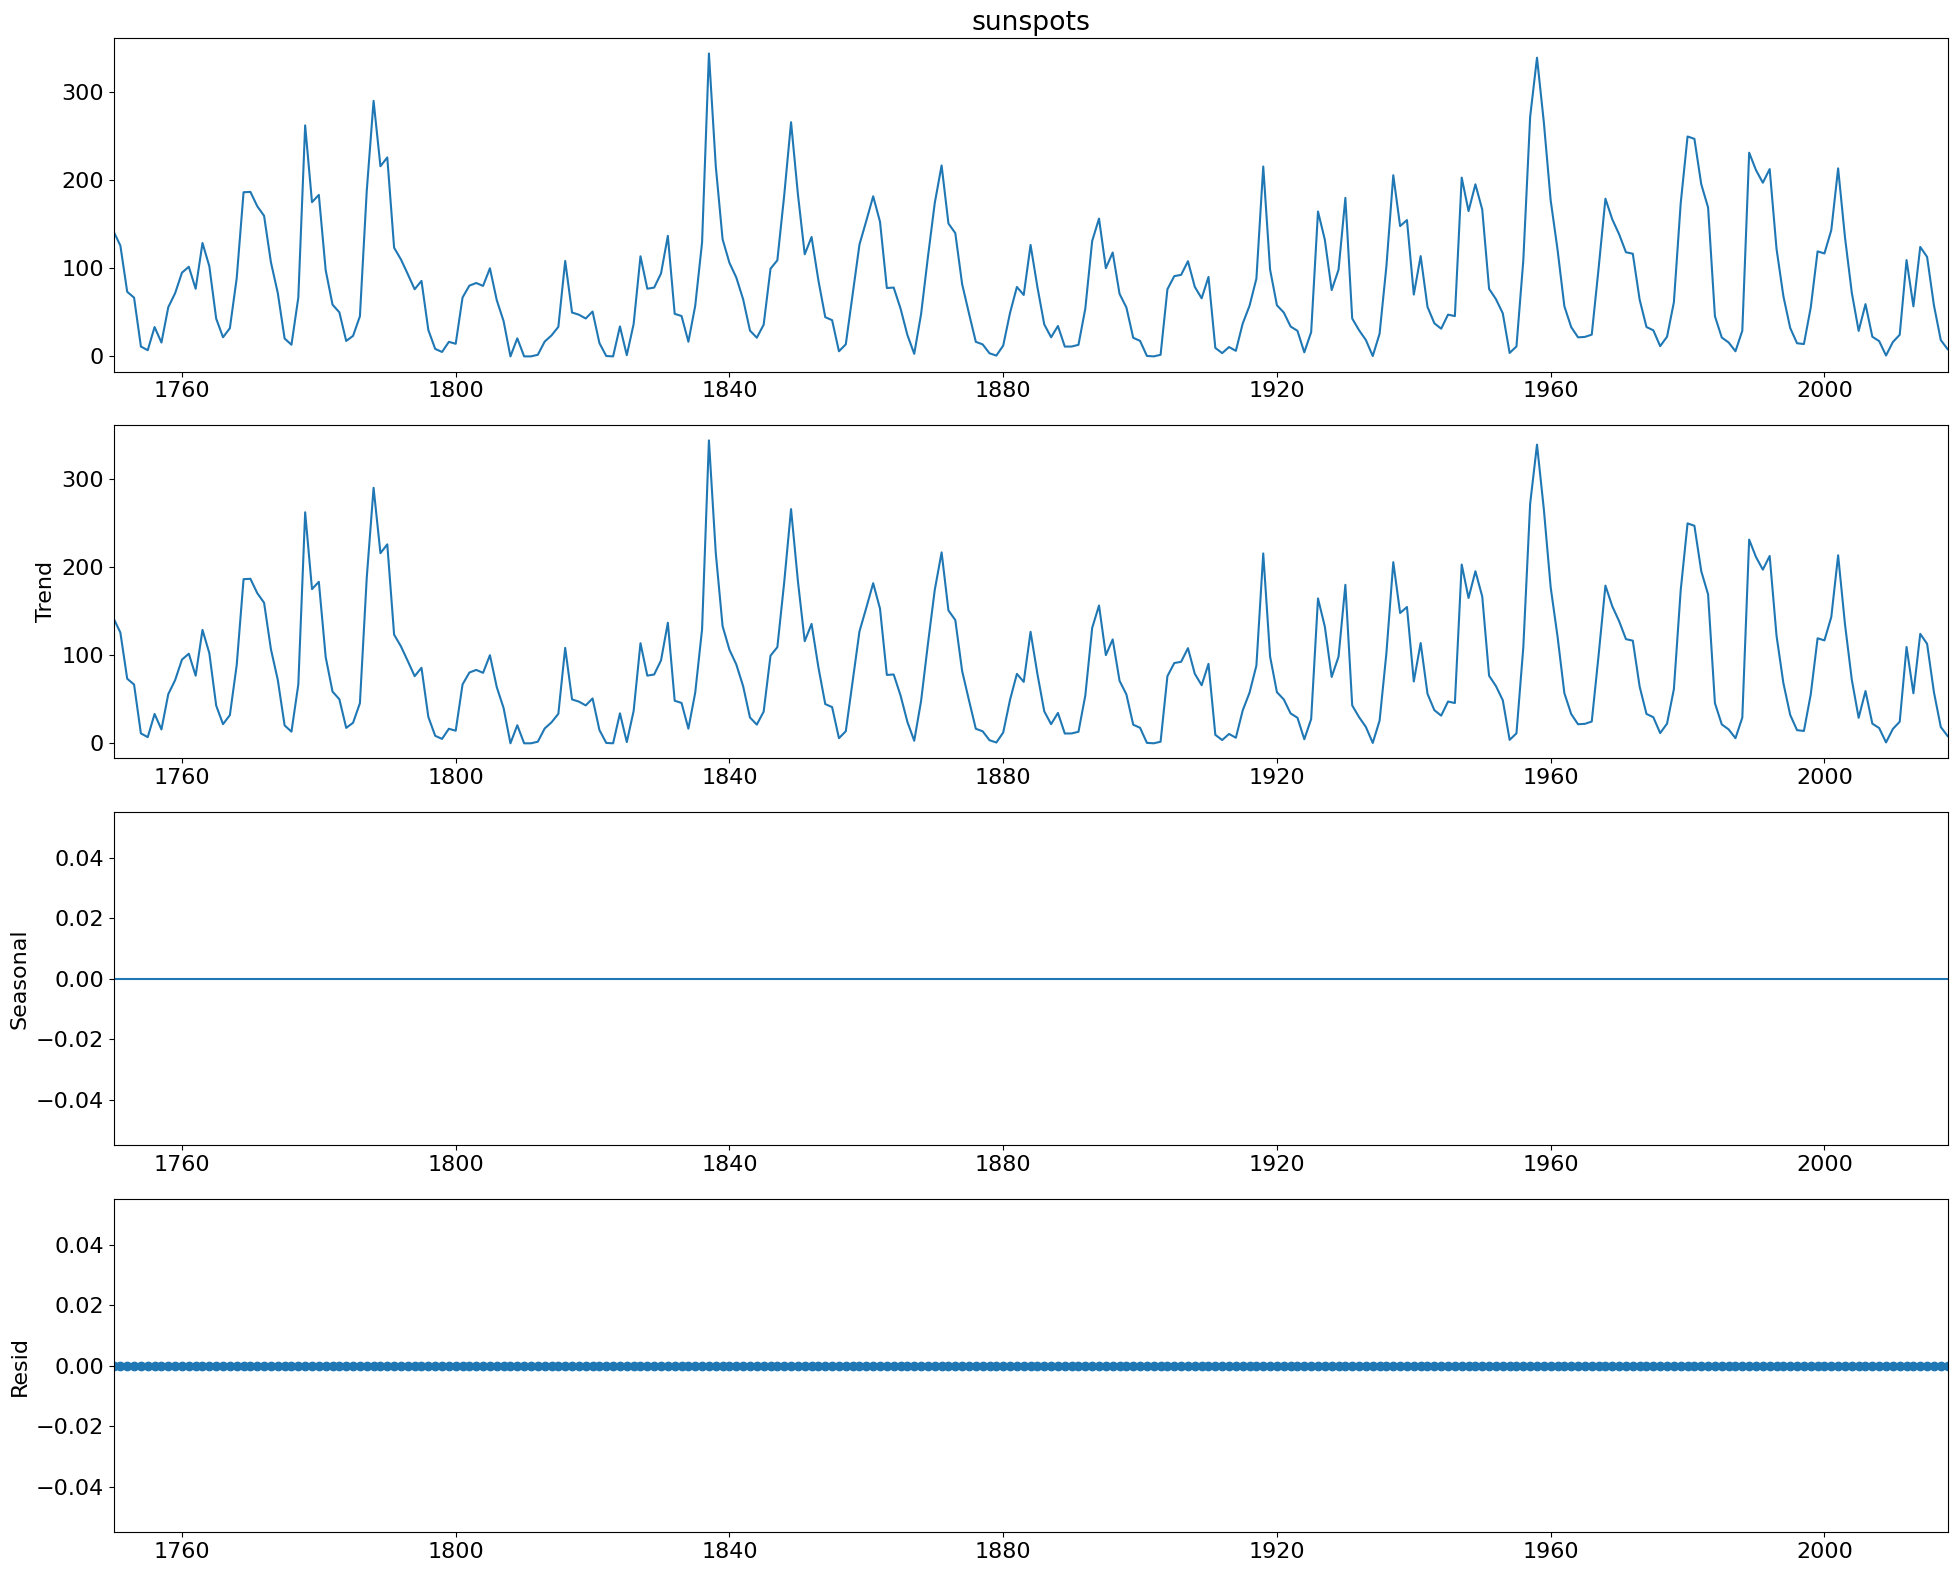

In [177]:
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose

rcParams.update({
    'figure.figsize': (20, 16),
    'font.size': 16,
})

idx = pd.Index(sm.tsa.datetools.dates_from_range('1749', '2017'))

result = seasonal_decompose(data.sunspots[idx], model='additive')
result.plot();

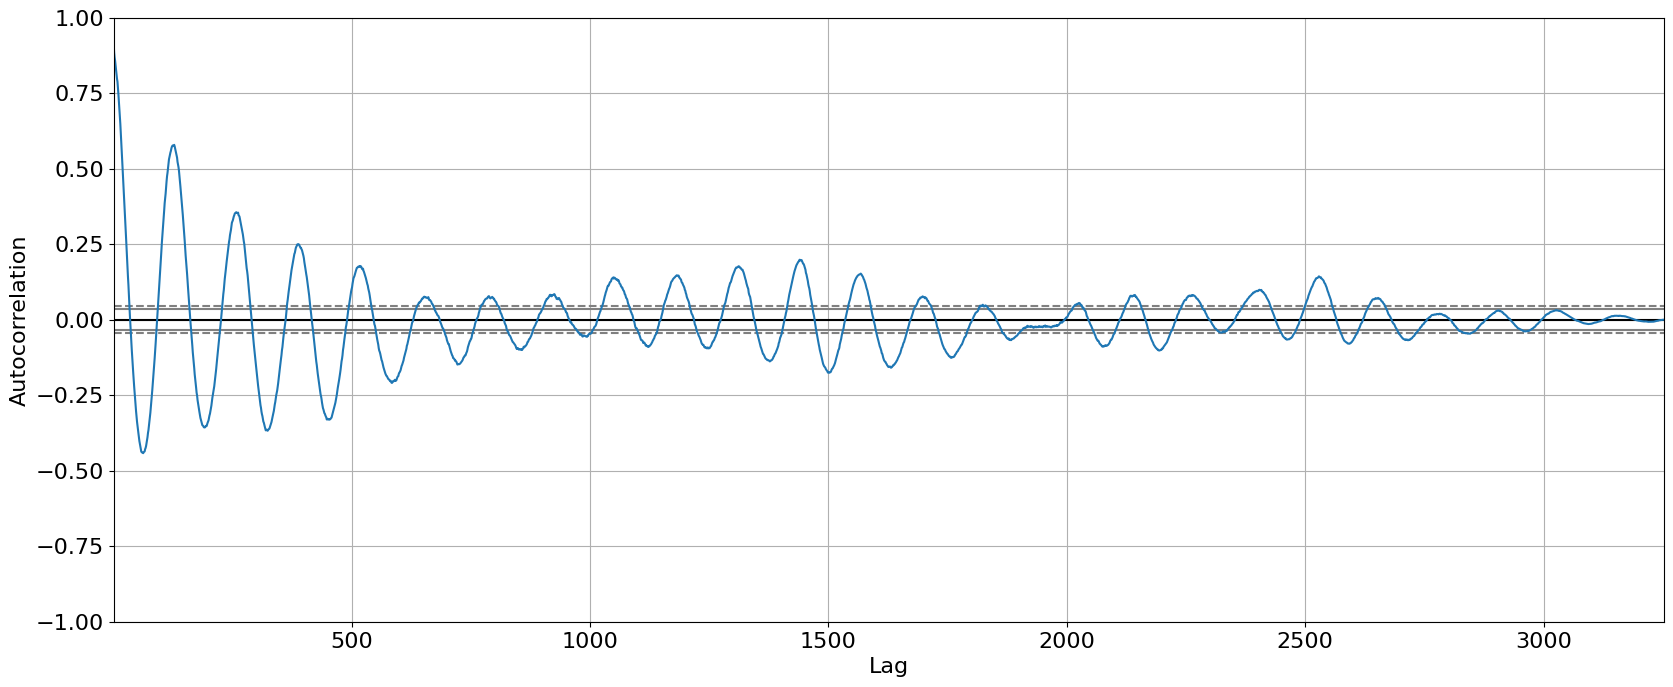

In [190]:
from pandas.plotting import autocorrelation_plot

rcParams.update({'figure.figsize': (20, 8)})

autocorrelation_plot(data.sunspots)

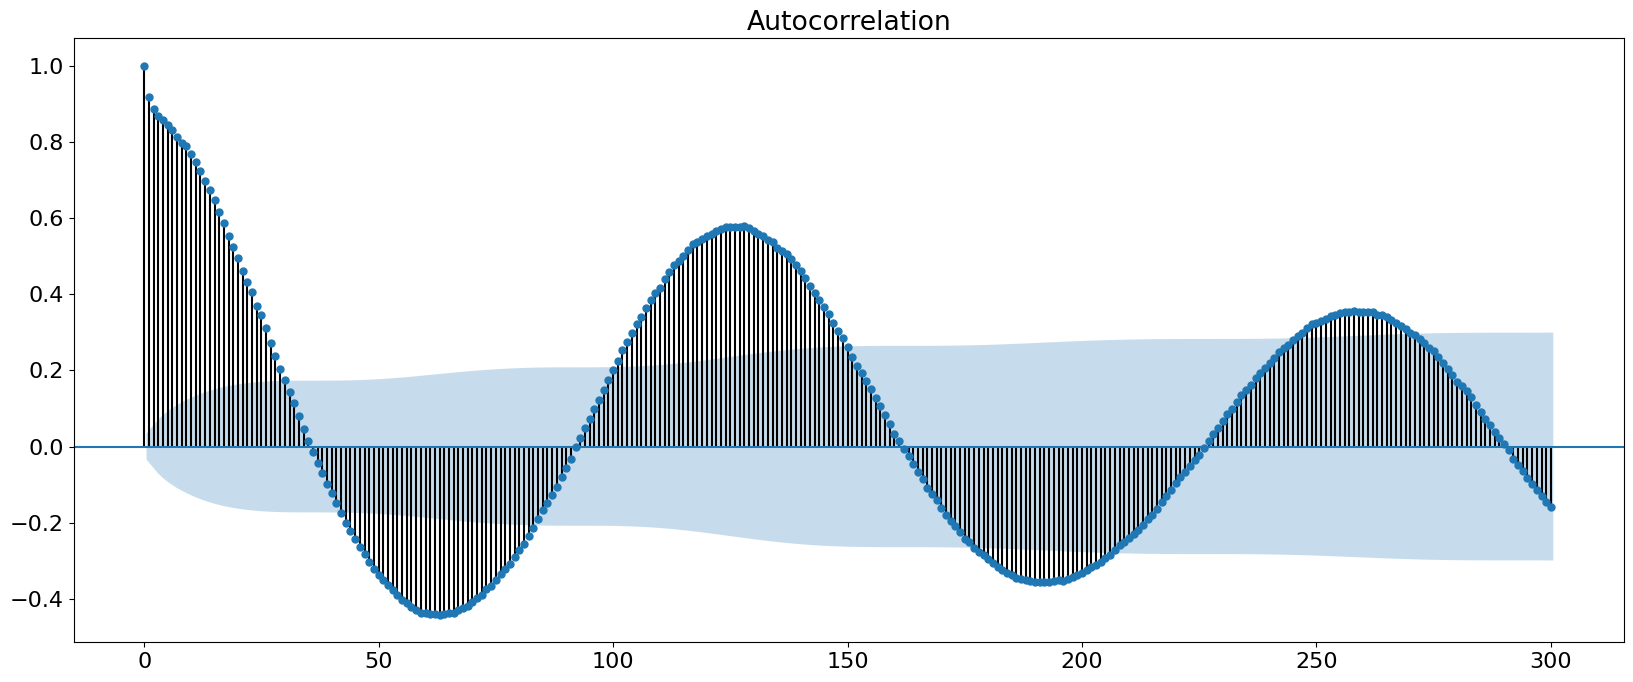

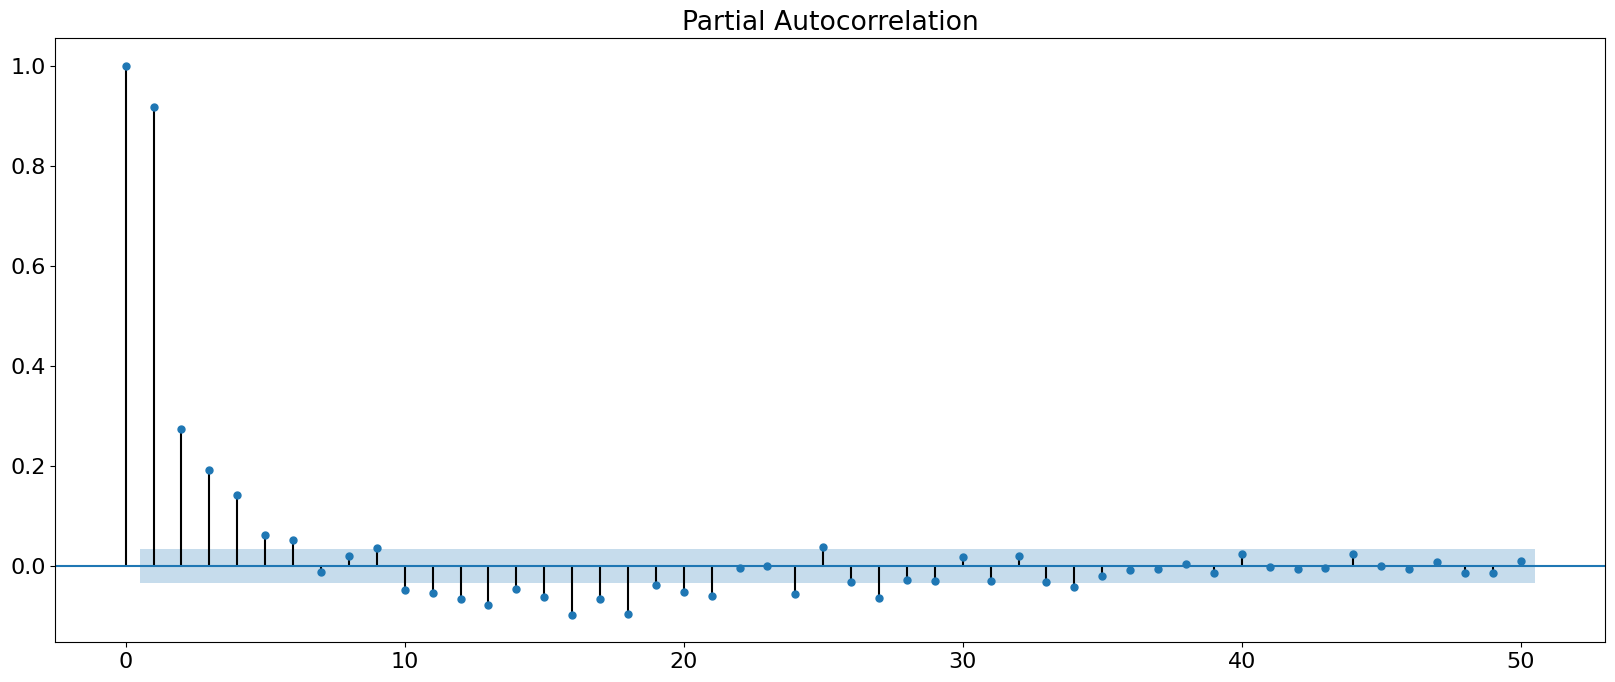

In [250]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data.sunspots, lags=300);
plot_pacf(data.sunspots, lags=50);

In [186]:
def trendline(index, data, order=1):
    coeffs = np.polyfit(index, data, order)
    slope = coeffs[-2]
    return float(slope)

trendline(range(data.sunspots.count()), data.sunspots)

0.0031718163496368117

> slope is a zero value: **No trend**

### 2. train / test split

In [283]:
import statsmodels.api as sm

train = pd.Index(sm.tsa.datetools.dates_from_range('1749', '2008'))
test = pd.Index(sm.tsa.datetools.dates_from_range('1990', '2012'))

train[0], train[-1], test[0], test[-1]

(Timestamp('1749-12-31 00:00:00'),
 Timestamp('2008-12-31 00:00:00'),
 Timestamp('1990-12-31 00:00:00'),
 Timestamp('2012-12-31 00:00:00'))

### 3. forecast with ARIMA

The parameters of the ARIMA model are defined as follows:

- `p`: The number of lag observations included in the model, also called the lag order.
- `d`: The number of times that the raw observations are differenced, also called the degree of differencing.
- `q`: The size of the moving average window, also called the order of moving average.

In [284]:
%%time

model = sm.tsa.ARIMA(data.sunspots[train], order=(10, 1, 0)).fit()  
model.summary()

/home/drapegnik/.pyenv/versions/3.7.6/envs/bsuir/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  % freq, ValueWarning)
/home/drapegnik/.pyenv/versions/3.7.6/envs/bsuir/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  % freq, ValueWarning)


CPU times: user 5.53 s, sys: 8.36 s, total: 13.9 s
Wall time: 1.79 s


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:             D.sunspots   No. Observations:                  259
Model:                ARIMA(10, 1, 0)   Log Likelihood               -1340.292
Method:                       css-mle   S.D. of innovations             42.551
Date:                Sun, 19 Apr 2020   AIC                           2704.583
Time:                        15:44:48   BIC                           2747.265
Sample:                    12-31-1750   HQIC                          2721.744
                         - 12-31-2008                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0073      0.647      0.011      0.991      -1.261       1.275
ar.L1.D.sunspots     -0.2378      0.062     -3.830      0.000      -0.360      -0.116
ar.L2.D.sunspots     -0.3383      0.063     -5.394      0.000      -0.461      -0.215
ar.L3.D.sunspots     -0.3577      0.063     -5.637      0.000      -0.482      -0.233
ar.L4.D.sunspots     -0.3664      0.062     -5.897      0.000      -0.488      -0.245
ar.L5.D.sunspots     -0.4772      0.062     -7.694      0.000      -0.599      -0.356
ar.L6.D.sunspots     -0.3655      0.062     -5.903      0.000      -0.487      -0.244
ar.L7.D.sunspots     -0.4126      0.062     -6.641      0.000      -0.534      -0.291
ar.L8.D.sunspots     -0.3039      0.063     -4.797      0.000      -0.428      -0.180
ar.L9.D.sunspots     -0.2025      0.063     -3.232      0.001      -0.325      -0.080
ar.L10.D.sunspots    -0.0884      0.062     -1.420      0.156      -0.210       0.034
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             0.8570           -0.5736j            1.0312           -0.0939
AR.2             0.8570           +0.5736j            1.0312            0.0939
AR.3             0.4850           -1.1203j            1.2208           -0.1850
AR.4             0.4850           +1.1203j            1.2208            0.1850
AR.5            -0.2311           -1.3342j            1.3541           -0.2773
AR.6            -0.2311           +1.3342j            1.3541            0.2773
AR.7            -0.8153           -1.0840j            1.3564           -0.3526
AR.8            -0.8153           +1.0840j            1.3564            0.3526
AR.9            -1.4411           -0.1980j            1.4547           -0.4783
AR.10           -1.4411           +0.1980j            1.4547            0.4783
------------------------------------------------------------------------------
"""

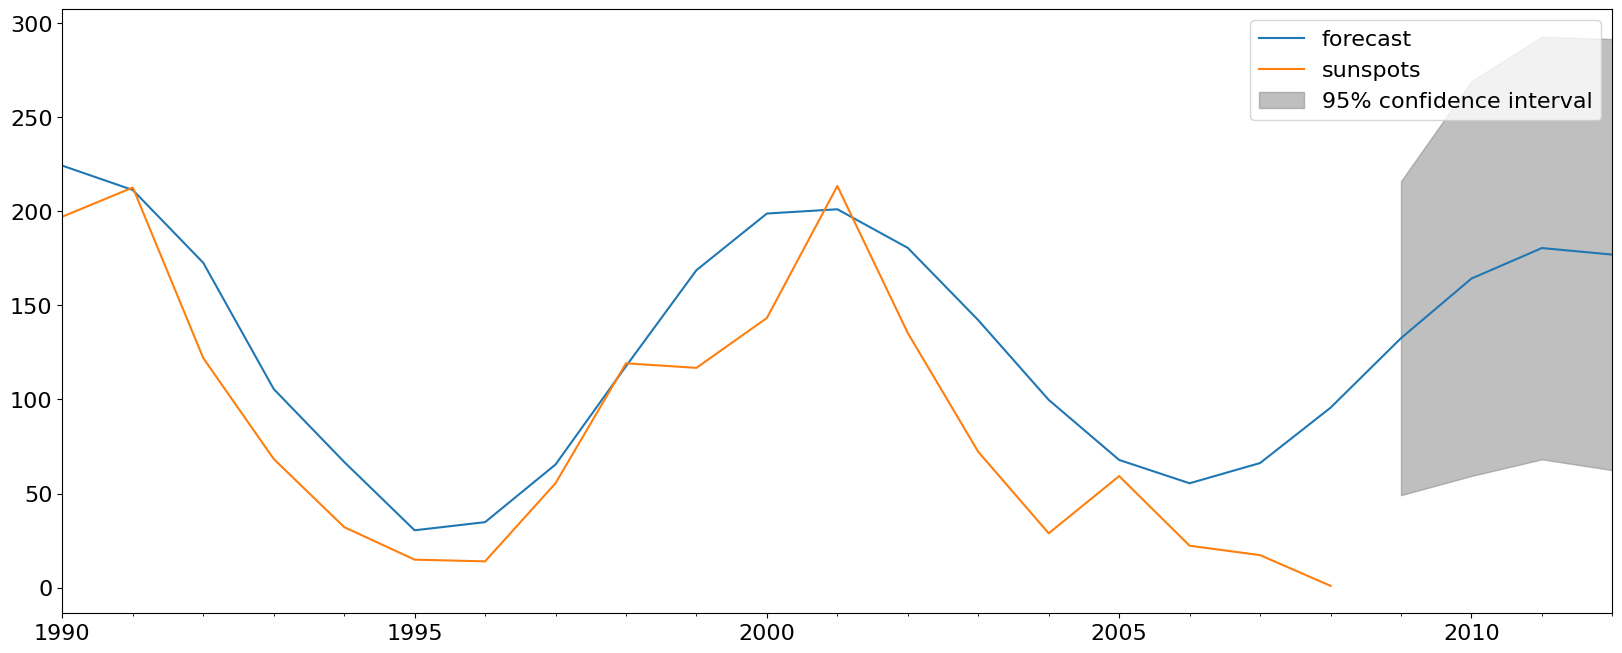

In [285]:
model.plot_predict('1990', '2012', dynamic=True);

### 4. build rnn

In [329]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

TIME_PERIOD = 12

def build_model(input_shape):
    model = Sequential()
    model.add(GRU(TIME_PERIOD, input_shape=input_shape, return_sequences=True))
    model.add(GRU(TIME_PERIOD))
    model.add(Dense(1))
    return model

In [330]:
def normalize(df):
    mean = df.sunspots.mean()
    std = df.sunspots.std()
    df['sunspots_norm'] = (df.sunspots - mean) / std
    return df
    
normalize(data)

,index,sunspots,sunspots_norm
Date,,,
1749-01-31,0,96.7,0.215566
1749-02-28,1,104.3,0.327553
1749-03-31,2,116.7,0.510270
1749-04-30,3,92.8,0.158098
1749-05-31,4,141.7,0.878649
...,...,...,...
2019-08-31,3247,0.5,-1.201960
2019-09-30,3248,1.1,-1.193119
2019-10-31,3249,0.4,-1.203433


In [404]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, shuffle=False)
test, val = train_test_split(test, test_size=0.5, shuffle=False)

train.shape, test.shape, val.shape

((2276, 3), (488, 3), (488, 3))

In [405]:
import tensorflow as tf

BATCH_SIZE = 256

def get_dataset(df, time_period=TIME_PERIOD, shuffle=False, batch_size=BATCH_SIZE, raw=False):
    X = []
    y = []
    
    for i in range(time_period, len(df)):
        prev_v = np.array(df['sunspots_norm'][i-time_period:i])
        next_v = df['sunspots_norm'][i]
        
        X.append(prev_v)
        y.append(next_v)
        
    X = np.array(X)
    X = np.expand_dims(X, axis=-1)
    y = np.array(y)
    
    if raw:
        return X, y
    
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(10000)
    ds = ds.batch(batch_size).repeat()
    return ds

In [406]:
train_ds = get_dataset(data, shuffle=True)
test_ds = get_dataset(data)

In [407]:
input_shape = train_ds.element_spec[0].shape[1:]
input_shape

TensorShape([12, 1])

In [408]:
model = build_model(input_shape)
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_9 (GRU)                  (None, 12, 12)            540       
_________________________________________________________________
gru_10 (GRU)                 (None, 12)                936       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 13        
Total params: 1,489
Trainable params: 1,489
Non-trainable params: 0
_________________________________________________________________


In [409]:
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    steps_per_epoch=100,
    validation_steps=30,
    callbacks=[EarlyStopping(patience=5)]
)

Train for 100 steps, validate for 30 steps
Epoch 1/10
100/100 [==============================] - 2s 23ms/step - loss: 0.2556 - val_loss: 0.1576
Epoch 2/10
100/100 [==============================] - 1s 7ms/step - loss: 0.1551 - val_loss: 0.1445
Epoch 3/10
100/100 [==============================] - 1s 7ms/step - loss: 0.1448 - val_loss: 0.1378
Epoch 4/10
100/100 [==============================] - 1s 7ms/step - loss: 0.1399 - val_loss: 0.1346
Epoch 5/10
100/100 [==============================] - 1s 7ms/step - loss: 0.1374 - val_loss: 0.1334
Epoch 6/10
100/100 [==============================] - 1s 7ms/step - loss: 0.1371 - val_loss: 0.1322
Epoch 7/10
100/100 [==============================] - 1s 7ms/step - loss: 0.1363 - val_loss: 0.1318
Epoch 8/10
100/100 [==============================] - 1s 7ms/step - loss: 0.1352 - val_loss: 0.1318
Epoch 9/10
100/100 [==============================] - 1s 7ms/step - loss: 0.1359 - val_loss: 0.1316
Epoch 10/10
100/100 [==============================] - 1

In [410]:
X_test, y_test = get_dataset(test, raw=True)
X_val, y_val = get_dataset(val, raw=True)

In [411]:
test_loss = model.evaluate(X_test, y_test)
val_loss = model.evaluate(X_val, y_val)

print(f'Test loss:\t{test_loss:.2%}')
print(f'Validation loss:\t{val_loss:.2%}')

476/476 [==============================] - 0s 43us/sample - loss: 0.1146
Test loss:	14.66%
Validation loss:	11.46%


In [412]:
mean = data.sunspots.mean()
std = data.sunspots.std()

def predict(X):
    shift = [None] * TIME_PERIOD
    predict = mean + model.predict(X) * std
    return shift + list(predict.flatten())

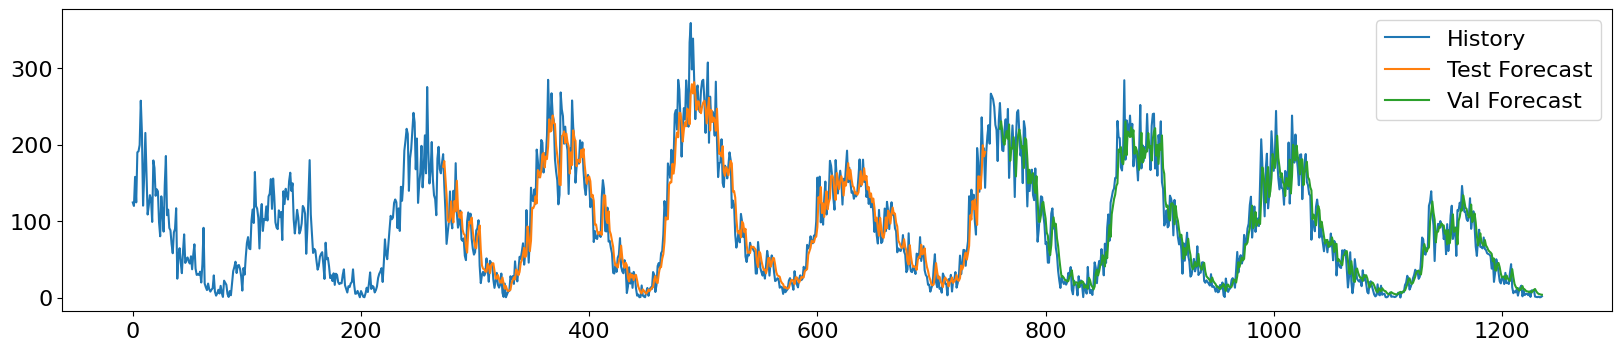

In [431]:
HISTORY_FROM = '1917'
history = data.loc[HISTORY_FROM:]
train_size = len(train.loc[HISTORY_FROM:])
train_with_test_size = train_size + len(test)
full_size = train_with_test_size + len(val)

plt.figure(figsize=(20, 4))
plt.plot(np.arange(full_size), history.sunspots, label='History')
plt.plot(np.arange(train_size, train_with_test_size), predict(X_test), label='Test Forecast')
plt.plot(np.arange(train_with_test_size, full_size), predict(X_val), label='Val Forecast')
plt.legend()
plt.show()